# **eZnalec - Price predicting & analytic model for apartments**

In [106]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data preparation (MICE)

Load the data

In [107]:
df = pd.read_csv('merged_apt_data.csv')
df.head()


,price,1+1,1+kk,2+1,2+kk,3+1,3+kk,4+1,4+kk,5+1,...,kindergarden,small_store,big_store,pub,restaurant,post_office,atm,nature_place,pharmacy,sports
0,6148000,0,0,0,1,0,0,0,0,0,...,577,319,966.0,1110,62,1003,693,2609.0,644,62
1,9490000,0,0,0,1,0,0,0,0,0,...,294,431,1809.0,301,197,364,523,NaN,609,387
2,19373005,0,0,0,0,0,1,0,0,0,...,319,707,707.0,1634,374,799,483,1883.0,776,676
3,7000000,0,0,0,1,0,0,0,0,0,...,196,76,1635.0,774,97,961,382,4511.0,542,81
4,26278859,0,0,0,0,0,1,0,0,0,...,468,732,1466.0,1017,619,1077,820,NaN,962,592


Inspect the missing data

In [108]:
missing_values = df.isnull().sum()
missing_values

#here we can see how many energy levels are missing in our dataset for example
missing_energy_level = df['energy_level'].isnull().sum()
missing_energy_level

np.int64(392)

Applying MICE

In [109]:
imputer = IterativeImputer()
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
#we can see that the energy levels which are not .00 are now imputed
df_imputed['energy_level'].head(30)

0     7.000000
1     1.000000
2     2.000000
3     4.000000
4     2.000000
5     3.439727
6     2.000000
7     2.000000
8     3.000000
9     2.000000
10    2.000000
11    7.000000
12    3.568650
13    2.000000
14    2.000000
15    4.000000
16    3.543069
17    2.650231
18    2.962034
19    4.923415
20    2.000000
21    2.000000
22    3.000000
23    7.000000
24    3.000000
25    7.000000
26    3.000000
27    3.000000
28    1.000000
29    4.000000
Name: energy_level, dtype: float64

Evaluation of imputation

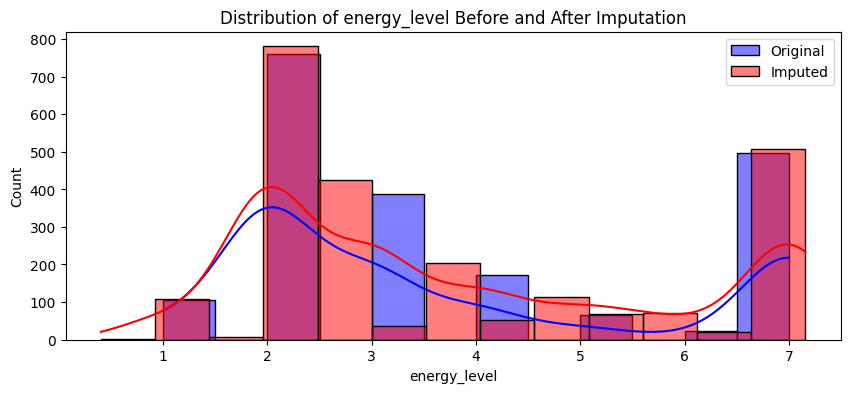

In [110]:
# Visualize the distribution of a few selected columns before and after imputation
import matplotlib.pyplot as plt
import seaborn as sns

# Select column to visualize
column = 'energy_level'  

plt.figure(figsize=(10, 4))

# Original data distribution
sns.histplot(df[column].dropna(), color='blue', label='Original', kde=True)

# Imputed data distribution
# This exapmle is for the energy level column, feel free to change the column name to visualize other columns
sns.histplot(df_imputed[column], color='red', label='Imputed', kde=True)

plt.title(f'Distribution of {column} Before and After Imputation')
plt.legend()



plt.show()

# Training the model

Data separation

In [129]:
y = df_imputed['price']
X = df_imputed.drop(columns=['price','price_per_m2'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear regression with elastic net normalization and cross-validation methodology for data

In [130]:
#first test on ols model, the most basic
ols = LinearRegression()
ols.fit(X_train, y_train)

print("r^2 on train data is {}".format(ols.score(X_train, y_train)))
print("r^2 on test data is {}".format(ols.score(X_test, y_test)))

r^2 on train data is 0.8443440414922742
r^2 on test data is 0.7853916855076359


Here it can be seen that on the test data, model can predict price on 78% accuracy, it is pretty good but it can be better.
Next will be ElasticNet normalization (L1+L2).

In [131]:
elastic_net = ElasticNet()
parameters = {
    'alpha': np.linspace(0.01, 10.0, 20),
    'l1_ratio': np.linspace(0.01, 0.9, 20)
}

grid_search = GridSearchCV(estimator=elastic_net, param_grid=parameters, cv=10, scoring='r2')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 on test data: ", r2)

Best parameters found:  {'alpha': np.float64(0.01), 'l1_ratio': np.float64(0.9)}
r2 on test data:  0.781811605306592


The best alpha (strength of the reqularization) is 0.01 and l1_ratio (lasso) is 0.90. Which means that we are using 90% Lasso and 10% Ridge. Plus we did 10 folds on cross validation for the data and the accuracy is now 78%.

# Analysis

## Feature importance

Text(0.5, 1.0, 'Top 20 Features in Elastic Net Model (absolute value of coefficients)')

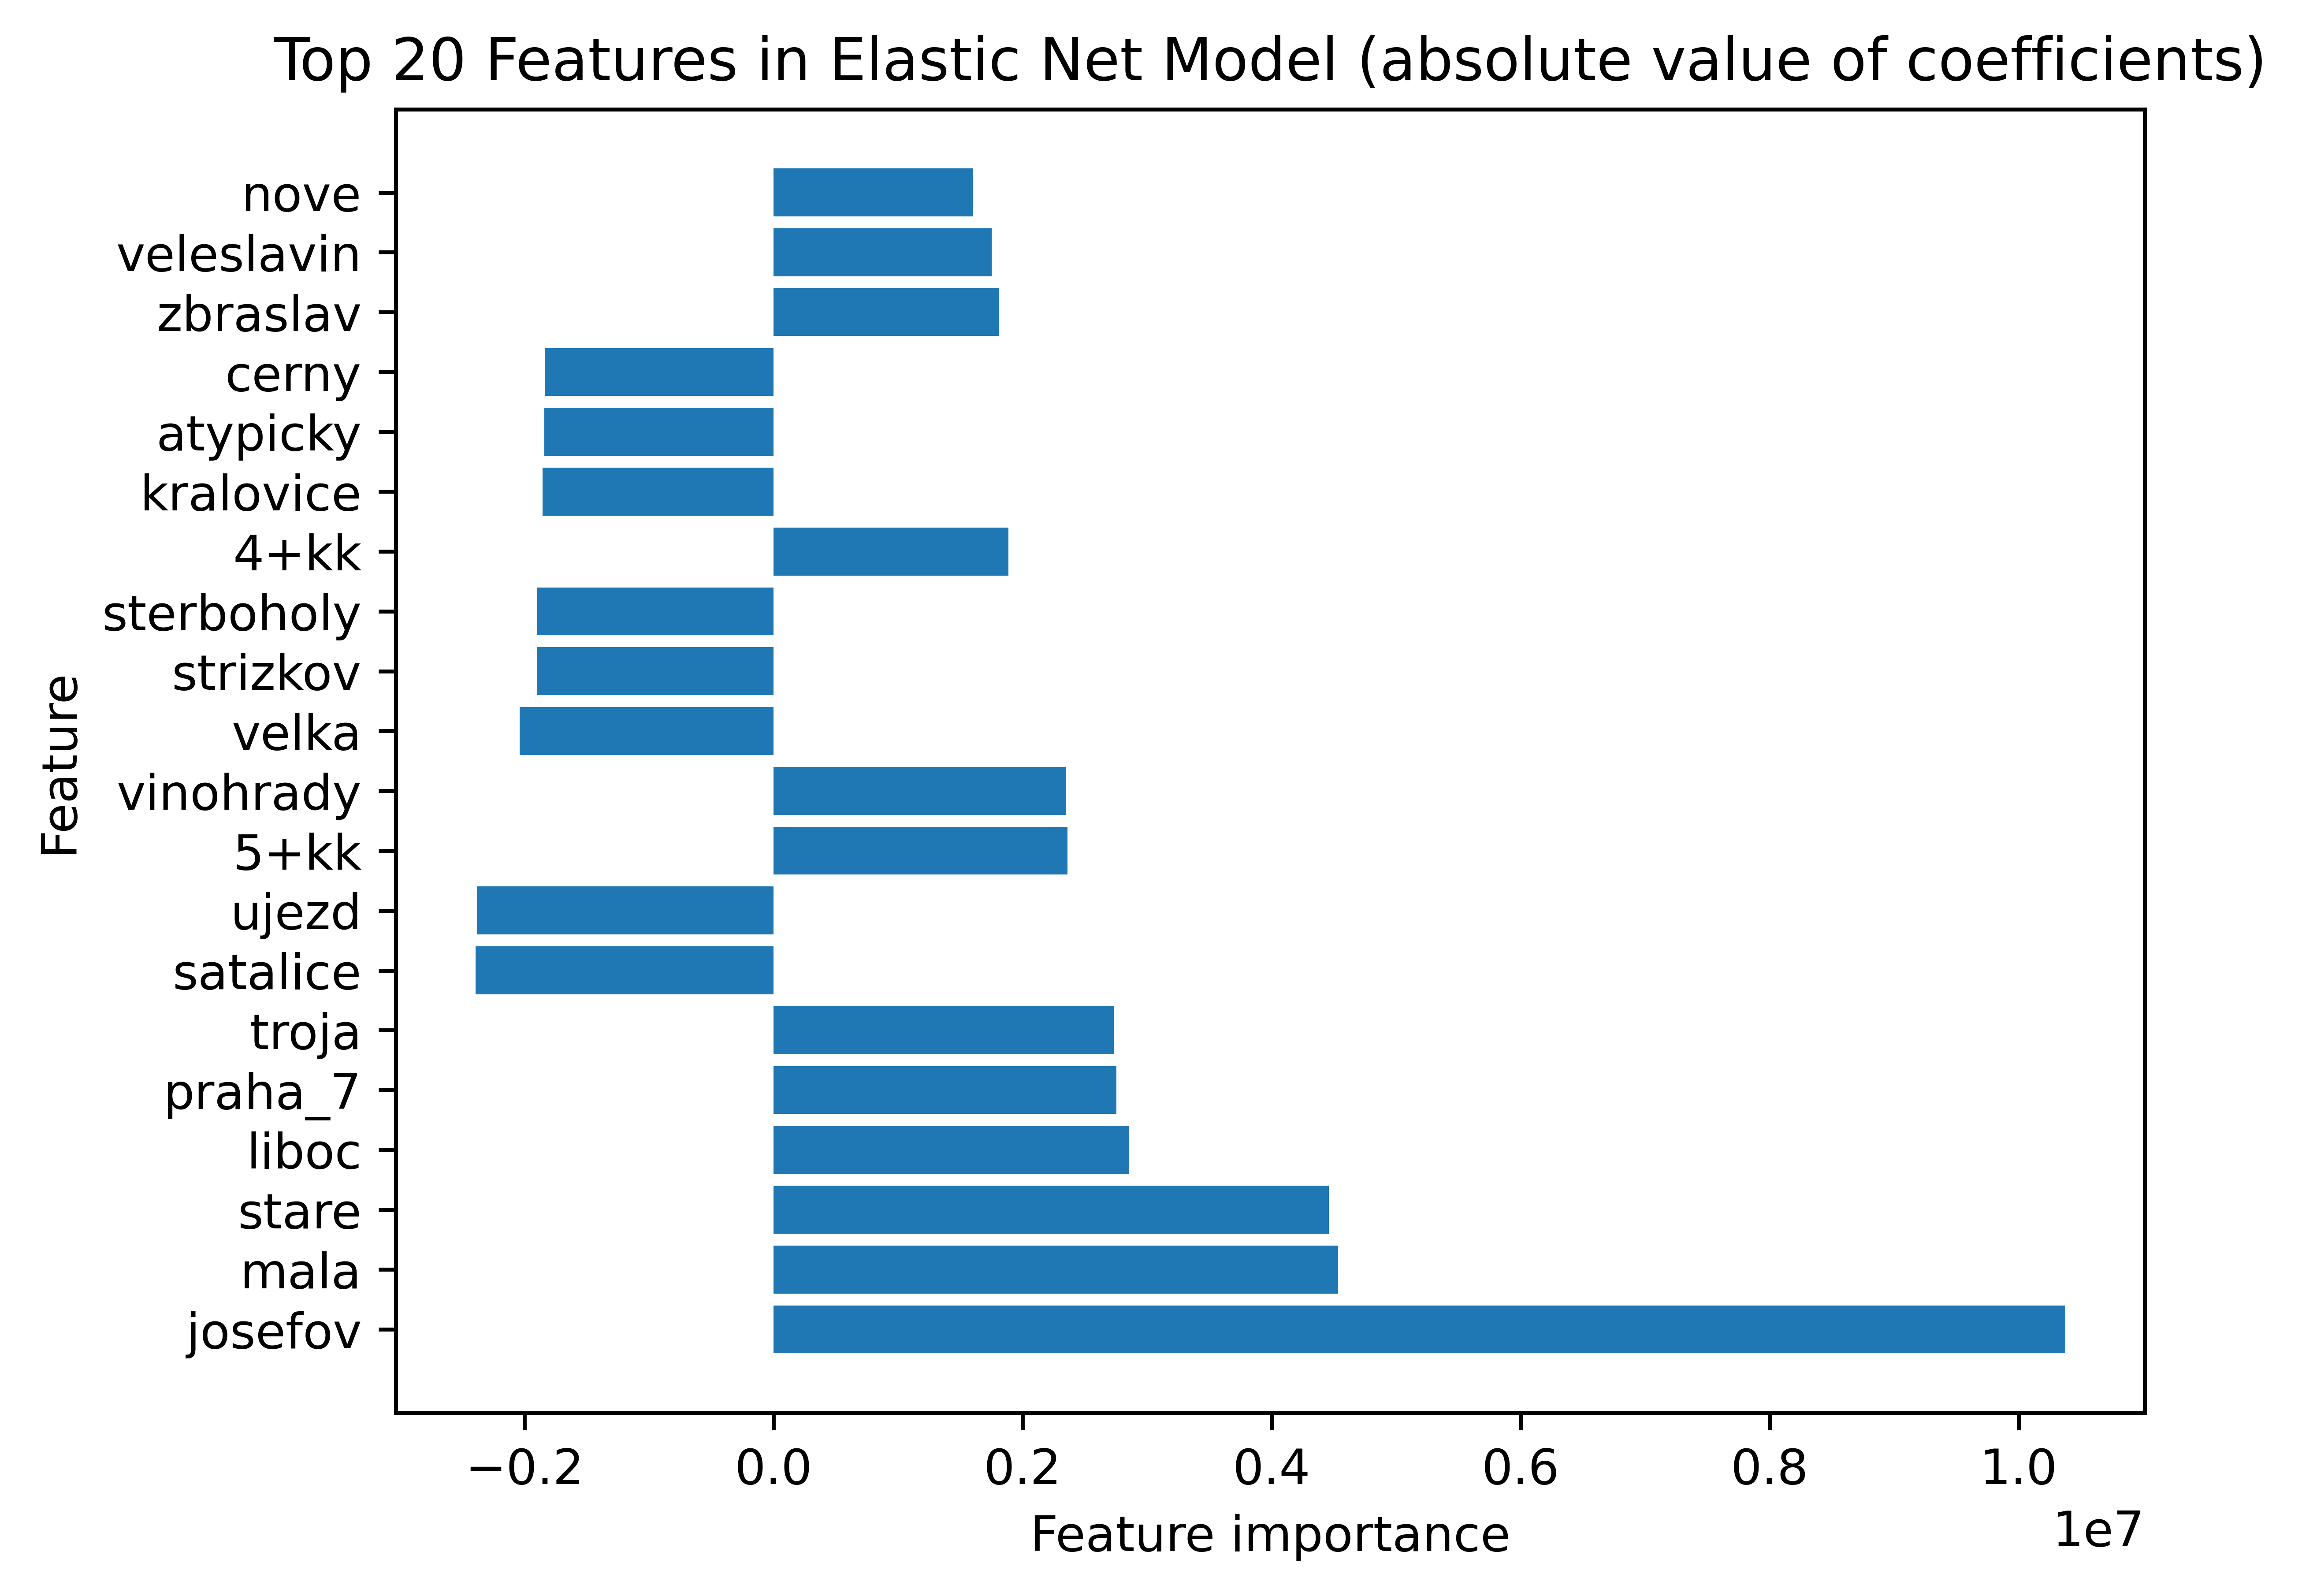

In [132]:
coef_abs = np.abs(best_model.coef_)
top_20_feature = np.argsort(coef_abs)[-20:][::-1]
plt.figure(dpi=800)
plt.barh(range(20), best_model.coef_[top_20_feature], align='center')
plt.yticks(range(20), X.columns[top_20_feature])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Top 20 Features in Elastic Net Model (absolute value of coefficients)")

- Here we can see that "thanks" for one-hot-encoding method for locations in prague most of the top 20 features are the specific location.
- Our model evaluated that Josefov (historical centre of Prague) is very imporant in price prediciting.
- Otherwise, we can see that the apartment's rooms dispositions are also very important, however, just the larger ones.

Next, locations and dispositions are going to general features not separate (one-hot-encoding style like now) 


In [133]:
#load the importance of the features into a dataframe
feature_importances = np.abs(best_model.coef_)

feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
})

locations = ['chodov',
                'hlubocepy',
                'smichov',
                'vysocany',
                'zizkov',
                'vinohrady',
                'modrany',
                'nove',
                'liben',
                'vrsovice',
                'cakovice',
                'krc',
                'nusle',
                'radlice',
                'satalice',
                'haje',
                'horni',
                'branik',
                'holesovice',
                'dolni',
                'stodulky',
                'mala',
                'praha_1',
                'kosire',
                'troja',
                'brevnov',
                'praha_8',
                'kyje',
                'vysehrad',
                'karlin',
                'kbely',
                'pitkovice',
                'sobin',
                'cerny',
                'treboradice',
                'cimice',
                'strizkov',
                'praha_9',
                'letnany',
                'kobylisy',
                'dejvice',
                'praha_14',
                'bubenec',
                'radotin',
                'ujezd',
                'suchdol',
                'hostavice',
                'praha_5',
                'podoli',
                'zlicin',
                'veleslavin',
                'michle',
                'hostivar',
                'strasnice',
                'petrovice',
                'praha_4',
                'zbraslav',
                'stare',
                'bohnice',
                'kolovraty',
                'kamyk',
                'trebonice',
                'zabehlice',
                'ruzyne',
                'jinonice',
                'malesice',
                'motol',
                'prosek',
                'vokovice',
                'repy',
                'hloubetin',
                'lochkov',
                'lipence',
                'liboc',
                'josefov',
                'hrdlorezy',
                'slivenec',
                'sterboholy',
                'praha_7',
                'hodkovicky',
                'cholupice',
                'miskovice',
                'uhrineves',
                'stresovice',
                'dubec',
                'lhotka',
                'velka',
                'pisnice',
                'klanovice',
                'dablice',
                'vinor',
                'holyne',
                'praha_10',
                'libus',
                'hajek',
                'praha_2',
                'reporyje',
                'seberov',
                'bechovice',
                'kolodeje',
                'hradcany',
                'praha_6',
                'tocna',
                'kralovice',
                'kunratice',
                'praha_11',
                'dolni_brezany',]

#identify the one-hot encoded locations
location_features = [col for col in X.columns if col in locations]

#sum the importances of the one-hot encoded location features
location_importance = feature_importances_df[feature_importances_df['feature'].isin(location_features)]['importance'].mean()

#exclude the one-hot encoded location features from the DataFrame
feature_importances_df = feature_importances_df[~feature_importances_df['feature'].isin(location_features)]

#create a new DataFrame for the new general location importance
location_importance_df = pd.DataFrame({'feature': ['location'], 'importance': [location_importance]})



#concatenate the new DataFrame with the original feature importances DataFrame
feature_importances_df = pd.concat([feature_importances_df, location_importance_df], ignore_index=True)

feature_importances_df

,feature,importance
0,1+1,1.190900e+06
1,1+kk,1.073725e+06
2,2+1,3.418585e+05
3,2+kk,4.971977e+05
4,3+1,9.610913e+05
5,3+kk,5.332865e+05
6,4+1,7.212382e+05
7,4+kk,1.885595e+06
8,5+1,2.954775e+05
9,5+kk,2.360480e+06


Now lets do the same for apartment's room layout

In [134]:
layouts = ['1+1',
                '1+kk',
                '2+1',
                '2+kk',
                '3+1',
                '3+kk',
                '4+1',
                '4+kk',
                '5+1',
                '5+kk',
                '6-a-vice',
                'atypicky',]

#identify the one-hot encoded layouts
layout_features = [col for col in X.columns if col in layouts]

#sum the importances of the one-hot encoded layout features
layout_importance = feature_importances_df[feature_importances_df['feature'].isin(layout_features)]['importance'].mean()

#exclude the one-hot encoded layout features from the DataFrame
feature_importances_df = feature_importances_df[~feature_importances_df['feature'].isin(layout_features)]

#create a new DataFrame for the new general layout importance
layout_importance_df = pd.DataFrame({'feature': ['layout'], 'importance': [layout_importance]})

#concatenate the new DataFrame with the original feature importances DataFrame
feature_importances_df = pd.concat([feature_importances_df, layout_importance_df], ignore_index=True)

feature_importances_df

,feature,importance
0,size,1.109680e+05
1,energy_level,4.358637e+04
2,floor,1.202451e+05
3,Ve velmi dobrem stavu,5.168835e+05
4,V dobrem stavu,9.306169e+05
5,Ve spatnem stavu,0.000000e+00
6,Ve vystavbe,4.208045e+05
7,Projekt,8.222164e+05
8,Novostavba,5.805791e+05
9,K demolici,0.000000e+00


- Now layouts and locations have their own general importance columns.
- Lets see the feature importance horizontal barchart again.

C:\Users\samok\AppData\Local\Temp\ipykernel_10108\2768433193.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_df, palette='dark')


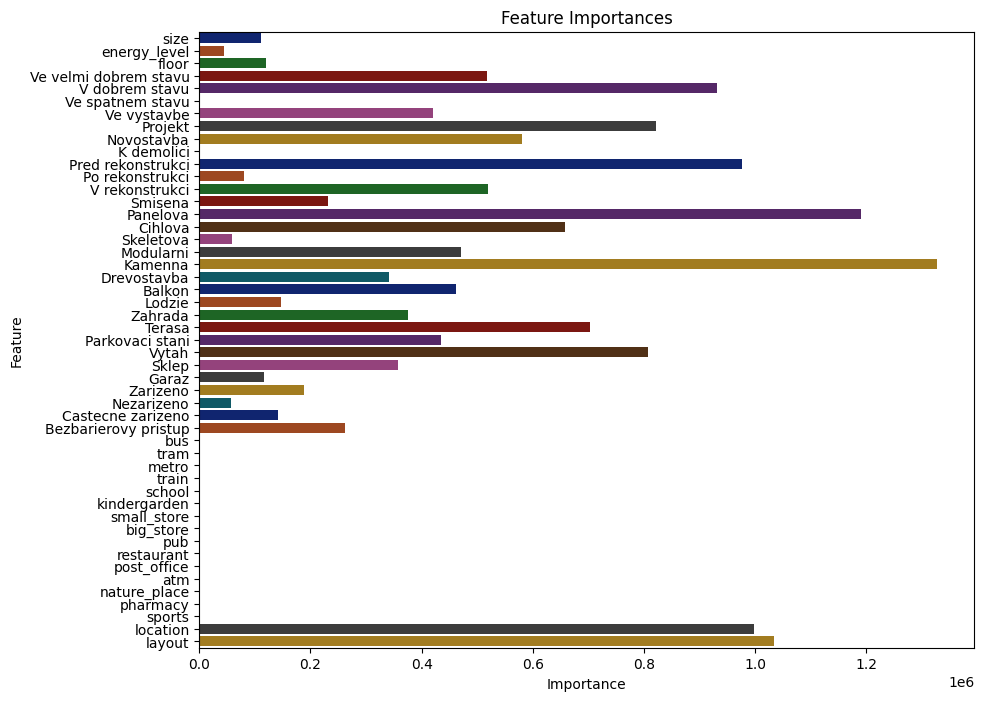

In [135]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df, palette='dark')

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- Here we can see that layout and location are similarly.
- Following with stone built (Kamenna) and then built with prefab. concrete (Panelova).
- Interesting is that we can see that 'Before renovation' (Pred rekonstrukci) is important, but most likely in price going down with this feature.
- It is also interesting that floor energy level and size is not that important for this model.
- All the features in 'bus' to 'sports' were proximities to that feature, this model set their importance to 0 because we are using Lasso (L1) regularization and this method can eliminate feature importance totally if evaluated.
- However in real life, these proximities are very important features in choosing your next apartment, but we can see that they are not important in overall price.

## Correlation matrix

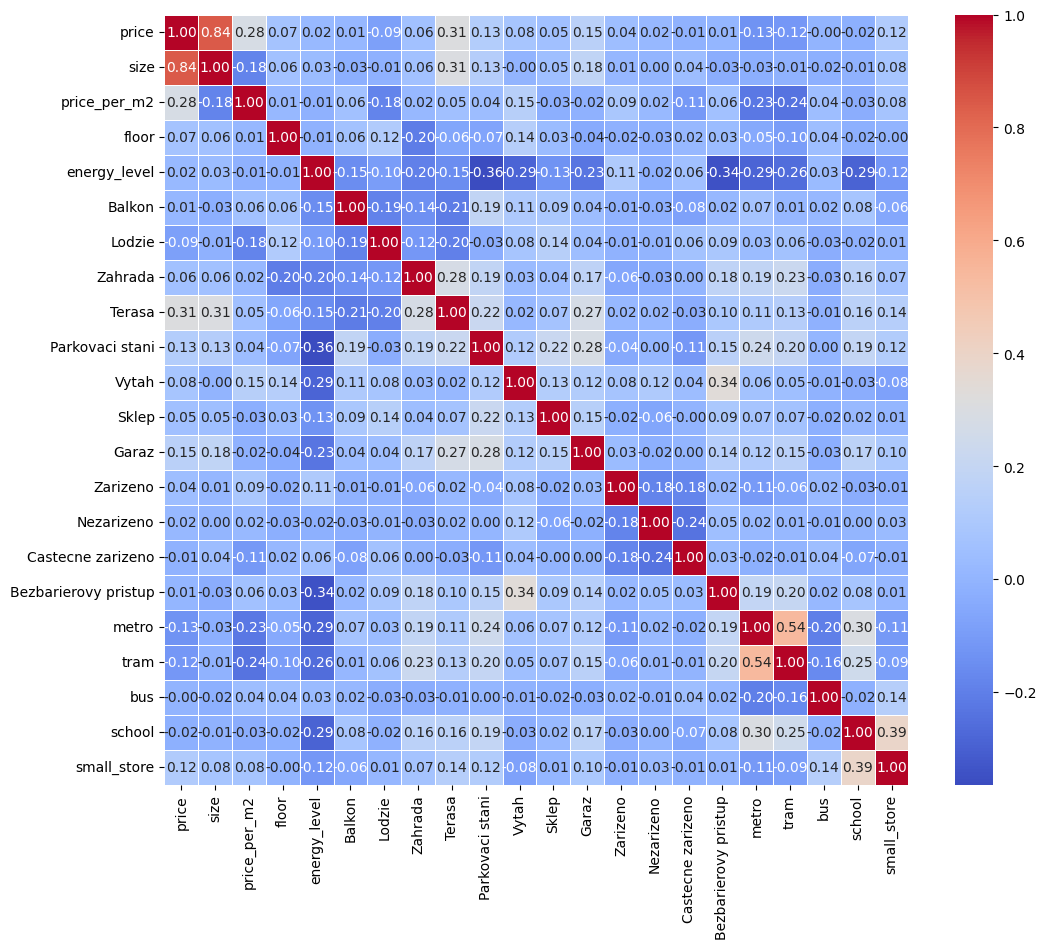

In [136]:
filtered_df = df_imputed[['price', 'size', 'price_per_m2', 'floor', 'energy_level', 'Balkon', 'Lodzie','Zahrada', 'Terasa', 'Parkovaci stani', 'Vytah', 'Sklep', 'Garaz', 'Zarizeno', 'Nezarizeno', 'Castecne zarizeno', 'Bezbarierovy pristup','metro', 'tram', 'bus','school', 'small_store']]
matrix = filtered_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

#display the plot
plt.show()

- Here we can see that size and terace has considerable correlation.
- More interesting considerable correlations: Garage and parking spot, garage and terace, accesiblity and elevator, tram and metro, school and small store, school and metro

# Test out the model with your apartment

Here, fill out the specs of your apartment:

In [137]:
my_apt = {#put 1 to your layout
                '1+1': 0,
                '1+kk': 0,
                '2+1': 0,
                '2+kk': 0,
                '3+1': 0,
                '3+kk': 1,
                '4+1': 0,
                '4+kk': 0,
                '5+1': 0,
                '5+kk': 0,
                '6-a-vice': 0,
                'atypicky': 0,
                #-------------
                #put 1 to your location, use ctrl+f to find your location, use only one location from this list
                'chodov': 0,
                'hlubocepy': 0,
                'smichov': 0,
                'vysocany': 0,
                'zizkov': 0,
                'vinohrady': 0,
                'modrany': 0,
                'nove': 0,
                'liben': 0,
                'vrsovice': 0,
                'cakovice': 0,
                'krc': 0,
                'nusle': 0,
                'radlice': 1,
                'satalice': 0,
                'haje': 0,
                'horni': 0,
                'branik': 0,
                'holesovice': 0,
                'dolni': 0,
                'stodulky': 0,
                'mala': 0,
                'praha_1': 0,
                'kosire': 0,
                'troja': 0,
                'brevnov': 0,
                'praha_8': 0,
                'kyje': 0,
                'vysehrad': 0,
                'karlin': 0,
                'kbely': 0,
                'pitkovice': 0,
                'sobin': 0,
                'cerny': 0,
                'treboradice': 0,
                'cimice': 0,
                'strizkov': 0,
                'praha_9': 0,
                'letnany': 0,
                'kobylisy': 0,
                'dejvice': 0,
                'praha_14': 0,
                'bubenec': 0,
                'radotin': 0,
                'ujezd': 0,
                'suchdol': 0,
                'hostavice': 0,
                'praha_5': 0,
                'podoli': 0,
                'zlicin': 0,
                'veleslavin': 0,
                'michle': 0,
                'hostivar': 0,
                'strasnice': 0,
                'petrovice': 0,
                'praha_4': 0,
                'zbraslav': 0,
                'stare': 0,
                'bohnice': 0,
                'kolovraty': 0,
                'kamyk': 0,
                'trebonice': 0,
                'zabehlice': 0,
                'ruzyne': 0,
                'jinonice': 0,
                'malesice': 0,
                'motol': 0,
                'prosek': 0,
                'vokovice': 0,
                'repy': 0,
                'hloubetin': 0,
                'lochkov': 0,
                'lipence': 0,
                'liboc': 0,
                'josefov': 0,
                'hrdlorezy': 0,
                'slivenec': 0,
                'sterboholy': 0,
                'praha_7': 0,
                'hodkovicky': 0,
                'cholupice': 0,
                'miskovice': 0,
                'uhrineves': 0,
                'stresovice': 0,
                'dubec': 0,
                'lhotka': 0,
                'velka': 0,
                'pisnice': 0,
                'klanovice': 0,
                'dablice': 0,
                'vinor': 0,
                'holyne': 0,
                'praha_10': 0,
                'libus': 0,
                'hajek': 0,
                'praha_2': 0,
                'reporyje': 0,
                'seberov': 0,
                'bechovice': 0,
                'kolodeje': 0,
                'hradcany': 0,
                'praha_6': 0,
                'tocna': 0,
                'kralovice': 0,
                'kunratice': 0,
                'praha_11': 0,
                'dolni_brezany': 0,
                #-------------
                #put the size of your apartment in m2
                'size': 100,
                #A to G = 1 to 7
                'energy_level': 1,
                'floor': 7,
                #-------------
                #put 1 to the conditions of your apartment
                'Ve velmi dobrem stavu': 0,
                'V dobrem stavu': 0,
                'Ve spatnem stavu': 0,
                'Ve vystavbe': 0,
                'Projekt': 0,
                'Novostavba': 1,
                'K demolici': 0,
                'Pred rekonstrukci': 0,
                'Po rekonstrukci': 0,
                'V rekonstrukci': 0,
                #-------------
                #put 1 to the build type of your apartment
                'Smisena': 0,
                'Panelova': 0,
                'Cihlova': 1,
                'Skeletova': 0,
                'Modularni': 0,
                'Kamenna': 0,
                'Drevostavba': 0,
                #-------------
                #put 1 to the features of your apartment
                'Balkon': 0,
                'Lodzie': 1,
                'Zahrada': 0,
                'Terasa': 1,
                'Parkovaci stani': 1,
                'Vytah': 0,
                'Sklep': 1,
                'Garaz': 1,
                'Zarizeno': 0,
                'Nezarizeno': 0,
                'Castecne zarizeno': 0,
                'Bezbarierovy pristup': 0,
                #-------------
                #put 1 to the nearby amenities of your apartment
                #you can leave these as 0, model is not sensitive to these
                'bus': 0,
                'tram': 0,
                'metro': 0,
                'train': 0,
                'school': 0,
                'kindergarden': 0,
                'small_store': 0,
                'big_store': 0,
                'pub': 0,
                'restaurant': 0,
                'post_office': 0,
                'atm': 0,
                'nature_place': 0,
                'pharmacy': 0,
                'sports': 0
}

data_point_df = pd.DataFrame([my_apt])

# if my_apt['price_per_m2'] == 0:
#     y2 = df_imputed['price_per_m2']
#     X2 = df_imputed.drop(columns=['price_per_m2', 'price'])

#     X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)    

#     ols2 = LinearRegression()
#     ols2.fit(X2_train, y2_train)
#     data_point_df2 = data_point_df
#     m2_price = ols2.predict(data_point_df2.drop(columns=['price_per_m2']))
#     m2_price = round(m2_price[0])
#     my_apt['price_per_m2'] = m2_price
#     data_point_df = pd.DataFrame([my_apt])
#     print("Price per m2 prediction:", m2_price, "CZK")




# Ensure the columns are in the same order as the training data
data_point_df = data_point_df[X.columns]

# Get the prediction
price_prediction = best_model.predict(data_point_df)
price_prediction = round(price_prediction[0])

print("price prediction:", price_prediction, "CZK")


price prediction: 13277094 CZK
